3D Visualization of Greedy-Selected Voxels for NC Detection
============================================================

Plots selected voxel centers in the LEGEND detector geometry,
draws the cylindrical detector outline, and performs PMT placement
validity checks (boundary constraints + mutual distance).

Structured for easy transfer into a Jupyter notebook — each section
corresponds to one cell.

Author: Thomas Bürger (University of Tübingen)

In [9]:
import json
from pathlib import Path
from typing import Union

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [10]:
# --- Detector geometry (mm) ---
R_ZYLINDER = 4300       # Cylinder apothem / outer radius
H_ZYLINDER = 8900       # Cylinder height
Z_BASE = -5000          # Bottom of cylinder (z coordinate)
Z_TOP = Z_BASE + H_ZYLINDER  # Top of cylinder

R_PIT = 3800            # Pit radius (circle at bottom)
R_ZYL_BOT = 3950        # Inner radius of bottom ring
R_ZYL_TOP = 1200        # Inner radius of top ring

PMT_RADIUS = 131        # PMT physical radius (mm)
MIN_PMT_DISTANCE = 2 * PMT_RADIUS  # Minimum center-to-center distance

# --- File paths (adjust as needed) ---
NPZ_PATH = Path("../selected/.npz")         # Greedy selection output
JSON_PATH = Path(
    "/global/cfs/projectdirs/legend/users/tbuerger/"
    "postprocessing/src/voxels/currentDistZylVoxelsPMTSize.json"
)

In [ ]:
def load_selected_voxel_ids(npz_path: Union[str, Path]) -> list[str]:
    """Load selected voxel IDs from greedy algorithm output."""
    data = np.load(npz_path, allow_pickle=True)
    ids = data["selected_voxel_ids"]
    print(f"Loaded {len(ids)} selected voxel IDs from {npz_path}")
    print(f"  N={int(data['N'])}, M={int(data['M'])}, m={int(data['m'])}")
    print(f"  Final efficiency: {data['efficiencies'][-1]:.4%}")
    return [str(v) for v in ids]


def load_voxel_geometry(json_path: Union[str, Path]) -> dict:
    """
    Load voxel geometry from JSON.
    
    Returns dict mapping index string -> {center, corners, layer}.
    """
    with open(json_path, "r") as f:
        voxels_list = json.load(f)
    
    voxel_map = {}
    for v in voxels_list:
        voxel_map[v["index"]] = {
            "center": np.array(v["center"]),
            "corners": np.array(v["corners"]),
            "layer": v["layer"],
        }
    
    print(f"Loaded {len(voxel_map)} voxels from {json_path}")
    layer_counts = {}
    for v in voxel_map.values():
        layer_counts[v["layer"]] = layer_counts.get(v["layer"], 0) + 1
    for layer, count in sorted(layer_counts.items()):
        print(f"  {layer}: {count}")
    
    return voxel_map


# Load
selected_ids = load_selected_voxel_ids(NPZ_PATH)
voxel_map = load_voxel_geometry(JSON_PATH)

# Extract centers and layers for selected voxels
selected_centers = []
selected_layers = []
missing_ids = []

for vid in selected_ids:
    if vid in voxel_map:
        selected_centers.append(voxel_map[vid]["center"])
        selected_layers.append(voxel_map[vid]["layer"])
    else:
        missing_ids.append(vid)

selected_centers = np.array(selected_centers)
selected_layers = np.array(selected_layers)

if missing_ids:
    print(f"\nWARNING: {len(missing_ids)} selected voxel IDs not found in JSON!")
    print(f"  Missing: {missing_ids[:10]}{'...' if len(missing_ids) > 10 else ''}")

print(f"\nSuccessfully matched {len(selected_centers)} / {len(selected_ids)} voxels")


NameError: name 'load_selected_voxel_ids' is not defined

In [4]:
def is_valid_pmt_position(
    center: np.ndarray, layer: str, pmt_r: float = PMT_RADIUS
) -> bool:
    """Check if a PMT fits within the detector layer boundaries."""
    x, y, z = center
    r_center = np.sqrt(x**2 + y**2)

    if layer == "pit":
        return r_center + pmt_r <= R_PIT
    elif layer == "bot":
        return (r_center - pmt_r >= R_ZYL_BOT) and (r_center + pmt_r <= R_ZYLINDER)
    elif layer == "top":
        return (r_center - pmt_r >= R_ZYL_TOP) and (r_center + pmt_r <= R_ZYLINDER)
    elif layer == "wall":
        z_min_allowed = Z_BASE + pmt_r
        z_max_allowed = Z_BASE + (H_ZYLINDER - 1) - pmt_r  # h-1 consistent with script
        return z_min_allowed <= z <= z_max_allowed
    return False


def check_boundary_constraints(
    centers: np.ndarray, layers: np.ndarray, voxel_ids: list[str]
) -> list[int]:
    """
    Verify all selected voxels satisfy PMT boundary constraints.
    
    Returns list of indices that FAIL the check.
    """
    failures = []
    for i, (c, lay, vid) in enumerate(zip(centers, layers, voxel_ids)):
        if not is_valid_pmt_position(c, lay):
            failures.append(i)
            r = np.sqrt(c[0]**2 + c[1]**2)
            print(f"  FAIL: Voxel {vid} (layer={lay}, r={r:.1f}, z={c[2]:.1f})")
    return failures


def check_mutual_distances(
    centers: np.ndarray, voxel_ids: list[str], min_dist: float = MIN_PMT_DISTANCE
) -> list[tuple[int, int, float]]:
    """
    Check that all selected PMT centers are at least min_dist apart.
    
    Uses pairwise Euclidean distance. For N~300 this is O(N^2) which is fine.
    
    Returns list of (i, j, distance) tuples that violate the constraint.
    """
    n = len(centers)
    violations = []
    
    # Vectorized pairwise distance
    # For N=300: 300*300 = 90k pairs, trivial computation
    for i in range(n):
        # Compute distance from voxel i to all subsequent voxels
        diffs = centers[i + 1:] - centers[i]
        dists = np.linalg.norm(diffs, axis=1)
        
        too_close = np.where(dists < min_dist)[0]
        for idx in too_close:
            j = i + 1 + idx
            violations.append((i, j, dists[idx]))
    
    return violations


# --- Run checks ---
print("=" * 60)
print("CHECK 1: PMT boundary constraints")
print("=" * 60)
boundary_failures = check_boundary_constraints(selected_centers, selected_layers, selected_ids)
if not boundary_failures:
    print("  All voxels PASS boundary check.")
else:
    print(f"  {len(boundary_failures)} voxels FAIL boundary check!")

print(f"\n{'=' * 60}")
print(f"CHECK 2: Mutual PMT distance (min = {MIN_PMT_DISTANCE} mm)")
print("=" * 60)
distance_violations = check_mutual_distances(selected_centers, selected_ids)
if not distance_violations:
    print("  All pairwise distances PASS.")
else:
    print(f"  {len(distance_violations)} pairs too close!")
    for i, j, d in distance_violations[:20]:
        print(f"    Voxels {selected_ids[i]} <-> {selected_ids[j]}: {d:.1f} mm")
    if len(distance_violations) > 20:
        print(f"    ... and {len(distance_violations) - 20} more")


CHECK 1: PMT boundary constraints


NameError: name 'selected_centers' is not defined

NameError: name 'selected_layers' is not defined

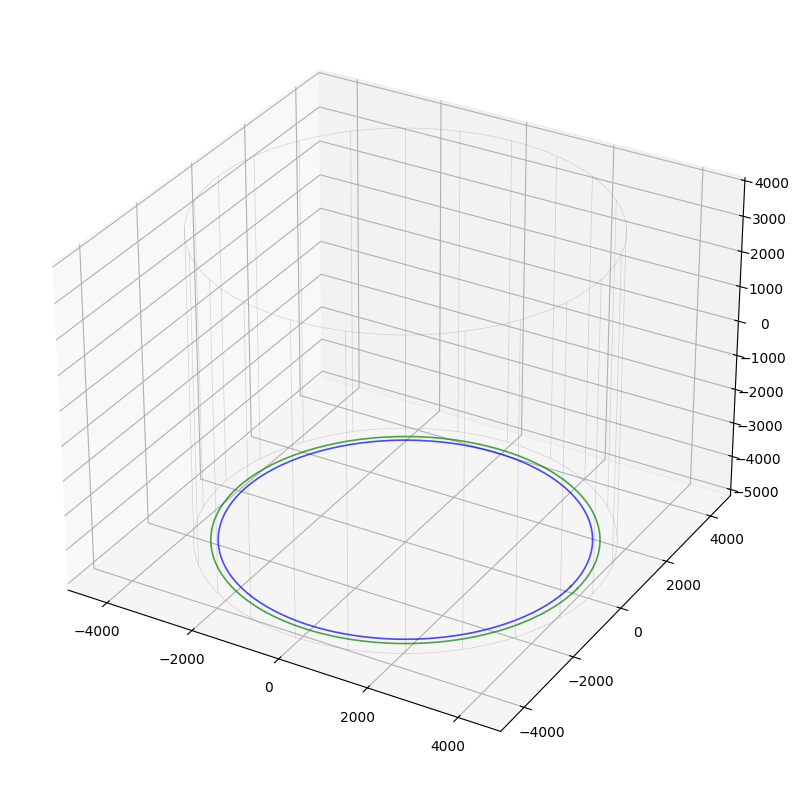

In [5]:
def draw_cylinder_wireframe(ax, r: float, z_bot: float, z_top: float,
                            n_lines: int = 24, color: str = "gray",
                            alpha: float = 0.3, linewidth: float = 0.5):
    """Draw wireframe cylinder (vertical lines + top/bottom circles)."""
    theta = np.linspace(0, 2 * np.pi, 200)
    
    # Bottom and top circles
    for z in [z_bot, z_top]:
        ax.plot(r * np.cos(theta), r * np.sin(theta), z,
                color=color, alpha=alpha, linewidth=linewidth)
    
    # Vertical lines
    theta_lines = np.linspace(0, 2 * np.pi, n_lines, endpoint=False)
    for t in theta_lines:
        ax.plot([r * np.cos(t)] * 2, [r * np.sin(t)] * 2, [z_bot, z_top],
                color=color, alpha=alpha, linewidth=linewidth)


def draw_circle(ax, r: float, z: float, color: str = "blue",
                alpha: float = 0.5, linewidth: float = 1.0, label: str = ""):
    """Draw a horizontal circle at given z."""
    theta = np.linspace(0, 2 * np.pi, 200)
    ax.plot(r * np.cos(theta), r * np.sin(theta), z,
            color=color, alpha=alpha, linewidth=linewidth, label=label)


# --- Create figure ---
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

# Detector cylinder
draw_cylinder_wireframe(ax, R_ZYLINDER, Z_BASE, Z_TOP)

# Bottom circles: pit (r=3800) and bot ring inner (r=3950)
draw_circle(ax, R_PIT, Z_BASE, color="blue", alpha=0.7, linewidth=1.2,
            label=f"Pit (r={R_PIT})")
draw_circle(ax, R_ZYL_BOT, Z_BASE, color="green", alpha=0.7, linewidth=1.2,
            label=f"Bot ring inner (r={R_ZYL_BOT})")

# --- Plot selected voxels by layer ---
layer_colors = {"pit": "red", "bot": "darkorange", "top": "magenta", "wall": "red"}
layer_markers = {"pit": "o", "bot": "s", "top": "^", "wall": "D"}

for layer in ["pit", "bot", "top", "wall"]:
    mask = selected_layers == layer
    if not np.any(mask):
        continue
    pts = selected_centers[mask]
    ax.scatter(
        pts[:, 0], pts[:, 1], pts[:, 2],
        c="red", marker=layer_markers.get(layer, "o"),
        s=30, alpha=0.8, edgecolors="darkred", linewidths=0.5,
        label=f"Selected ({layer}: {mask.sum()})",
    )

# Mark boundary failures (if any)
if boundary_failures:
    fail_pts = selected_centers[boundary_failures]
    ax.scatter(
        fail_pts[:, 0], fail_pts[:, 1], fail_pts[:, 2],
        c="yellow", marker="x", s=100, linewidths=2,
        label=f"Boundary violations ({len(boundary_failures)})",
    )

# Mark distance violations (if any)
if distance_violations:
    for i, j, d in distance_violations:
        p1, p2 = selected_centers[i], selected_centers[j]
        ax.plot(
            [p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
            color="yellow", linewidth=2, alpha=0.8,
        )

# --- Formatting ---
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.set_title(
    f"Selected Voxels (N={len(selected_centers)}, "
    f"boundary fails={len(boundary_failures)}, "
    f"distance violations={len(distance_violations)})"
)
ax.legend(loc="upper left", fontsize=8)

# Equal aspect ratio for all axes
max_range = max(R_ZYLINDER, (Z_TOP - Z_BASE) / 2)
mid_z = (Z_BASE + Z_TOP) / 2
ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.tight_layout()
plt.savefig("selected_voxels_3d.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"\nPlot saved to selected_voxels_3d.png")


In [6]:
print(f"\n{'=' * 60}")
print("SUMMARY")
print(f"{'=' * 60}")
print(f"Total selected voxels: {len(selected_centers)}")

for layer in ["pit", "bot", "top", "wall"]:
    count = np.sum(selected_layers == layer)
    if count > 0:
        pts = selected_centers[selected_layers == layer]
        r_vals = np.sqrt(pts[:, 0]**2 + pts[:, 1]**2)
        print(f"  {layer:>4}: {count:>4} voxels "
              f"(r: {r_vals.min():.0f}-{r_vals.max():.0f} mm, "
              f"z: {pts[:, 2].min():.0f}-{pts[:, 2].max():.0f} mm)")

print(f"\nBoundary check: {'PASS' if not boundary_failures else 'FAIL'}")
print(f"Distance check: {'PASS' if not distance_violations else 'FAIL'}")

if distance_violations:
    dists = [d for _, _, d in distance_violations]
    print(f"  Closest pair: {min(dists):.1f} mm (required: {MIN_PMT_DISTANCE} mm)")



SUMMARY


NameError: name 'selected_centers' is not defined